### При выполнении  домашней работы часть кода использовалась из следующего источника: 
https://towardsdatascience.com/learning-to-win-blackjack-with-monte-carlo-methods-61c90a52d53e 


#### Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
from blackjack import BlackjackEnv # В игре используется модифицированный класс для случая с подсчетом карт
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [2]:
game = BlackjackEnv()

Напишем стратегию игры, где игрок добирает карты пока в его руках меньше 19 очков

In [3]:
def play_game(game):
    game_steps = []
    reset = game.reset()
    episode = []
    game_steps.append([reset[0],0, 1.0 if reset[2] == True else 0.0])
    episode.append((reset[0], 0, 1.0 if reset[2] == True else 0.0))
    if reset[2] == True:
        return episode
    current = reset[0]
    while True:
        if current < 19:
            step = game.step(1)
            episode.append((step[0][0],1, step[1]))
            game_steps.append([step[0][0],1, step[1]])
        else: 
            step = game.step(0)
            episode.append((step[0][0],0, step[1]))
            game_steps.append([step[0][0],0, step[1]])
        done = step[2]
        current = step[0][0]
        if done:
            break
    else: 
        step = game.step(0)
        game_steps.append([step[0][0],0, step[1]])
        episode.append((step[0][0],0, step[1]))
    #if step[1] == 1.0:
    #    print ("WIN")
    return episode

Вспомогательные функции: обновление Q, подсчет среднего выигрыша 

In [4]:
def update_Q(episode, Q,returns_sum, N, gamma=1.0):
    """
    For each time step in the episode we carry out the first visit monte carlo method, checking if this is 
    the first index of this state. Get the discounted reward and add it to the total reward for that 
    state/action pair. Increment the times we have seen this state action pair and finally update the Q values
    """
    
    for s, a, r in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[s][a] += G
            N[s][a] += 1.0
            Q[s][a] = returns_sum[s][a] / N[s][a]

In [5]:
def mc_predict(game, num_episodes, gamma=1.0):

    """
    This is the primary method. Plays through several episodes of the environment. 
    """
    returns_sum = defaultdict(lambda: np.zeros(game.action_space.n))
    N = defaultdict(lambda: np.zeros(game.action_space.n))
    Q = defaultdict(lambda: np.zeros(game.action_space.n))
    res = []
    reward = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()            
        episode = play_game(game)
        reward.append(episode[-1][2])
        res.append(np.mean(np.array(reward)))
        update_Q(episode, Q, returns_sum, N)
            
    return Q, res

In [6]:
#можно не брать много наблюдений, в данном случае мы не обучаемся никакой стратегии
Q, mean_rewards = mc_predict(game, 1000)

Episode 1000/1000.

Зная стратегию, посчитаем среднее значение V функции

In [7]:
V_base = dict((k,(k>18)*(np.dot([1.0, 0.0],v)) + (k<=18)*(np.dot([0.0, 1.0],v))) \
         for k, v in Q.items())

In [8]:
summ = []
for k, v in V_base.items():
    summ.append(v)
res = np.array(summ)
print(np.mean(res))

-0.17551530411553207


Построим график усредненного дохода по количеству игр. Например, если мы играем 3 игры, то 3 точки на графике будут изображать полученный доход от одной игры, усредненный доход от 2 игр и усредненный доход от трех игр.

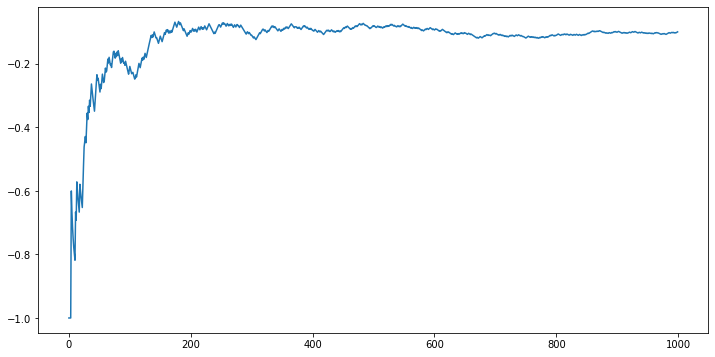

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_rewards)

Обыграть казино не получилось.

#### Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [10]:
import sys
import random
import gym
import numpy as np
from collections import defaultdict

Теперь добавились функции по получению вероятностей для выбора действия, функция, которая возвращает наилучшую политику на основании Q функции

In [11]:
def get_probs(Q_s, epsilon, nA):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


In [12]:
def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [13]:
def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """
    
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    
    return Q

In [14]:
def play_game(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [15]:
def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 0.9
    eps_min = 0.01
    #decay = 1
    alpha = 1e-1
    gamma = 1.0
    reward = []
    res = []
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        epsilon = epsilon * epsilon * 0.99
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = play_game(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        reward.append(episode[-1][2])
        res.append(np.mean(np.array(reward)))
    policy = best_policy(Q, nA)
    return policy, Q, res

Снова посчитаем V функцию, хотя в данном случае такой подсчет не несет в себе особенного смысла: для каждого состояния мы просто смотрим, какой наилучший выигрыш можем получить и дальше суммируем по всем состояниям.

In [16]:
V = dict((k,np.max(v)) for k, v in Q.items())

In [17]:
summ = []
for k, v in V.items():
    summ.append(v)
res = np.array(summ)
print(np.mean(res))

-0.01559739046164036


Обучаем наш алгоритм, играя 1000000 игр

In [18]:
policy, Q, mean_rewards_1 = mc_control(game, 100000)


Episode 100000/100000.

#### Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры

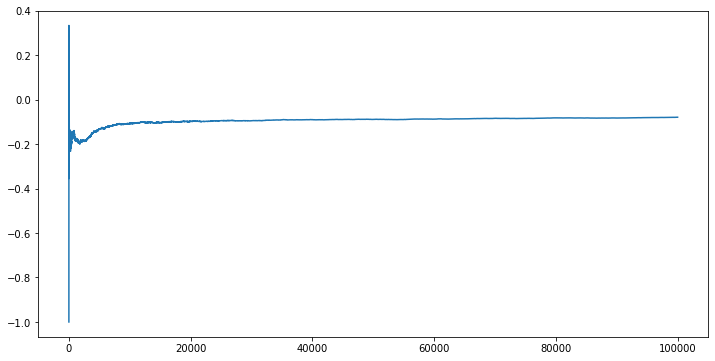

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_rewards_1)

In [52]:
mean_rewards_1[-1]

-0.07926

### Прогоны с другими гиперпараметрами вынесены в отдельный документ (pdf). В тех экспериментах не было итеративного уменьшения эпсилона.

## Double

#### Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [20]:
def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [21]:
def get_probs(Q_s, epsilon, nA):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

Расширяем пространство действий до трех, добавляем условие игры для удвоения (действие 2). Остальное остается прежним

In [22]:
def play_game_double(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else np.random.choice(np.arange(nA))
        if action < 2:
            next_state, reward, done, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        else:
            # double стратегия
            next_state, reward, done, info = env.step(1)
            episode.append((state, action, reward*2))
            break
        if done:
            break
    return episode

In [23]:
def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """
    
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    
    return Q

In [24]:
def mc_control_double(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 0.9
    eps_min = 0.01
    #decay = 1
    alpha = 1e-1
    gamma = 1.0
    reward = []
    res = []
    nA = 3
    Q = defaultdict(lambda: np.zeros(nA))
    for i_episode in range(1, num_episodes+1):
        epsilon = epsilon * 0.99
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = play_game_double(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
        reward.append(episode[-1][2])
        res.append(np.mean(np.array(reward)))
    policy = best_policy(Q, nA)
    return policy, Q, res

Аналогично прошлому пункту: обучим нашу стратегию на 100000 игр, посчитаем среднее V и построим график среднего дохода

In [25]:
policy, Q, mean_rewards_double = mc_control_double(game, 100000)

Episode 100000/100000.

In [26]:
V = dict((k,np.max(v)) for k, v in Q.items())

In [27]:
summ = []
for k, v in V.items():
    summ.append(v)
res = np.array(summ)
print(np.mean(res))

0.037687025428815246


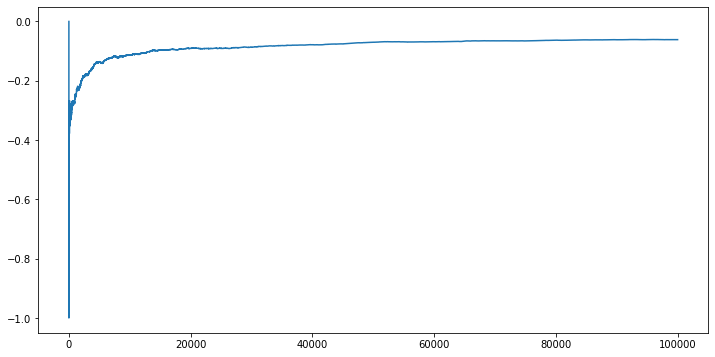

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_rewards_double)

In [53]:
mean_rewards_double[-1]

-0.06132

И снова казино остается в плюсе, а игрок - в минусе.

## Cards calculation

#### Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


Из википедии, метод "Плюс-минус": вспоминаем фильм 21 и считаем насколько наша колода "холодная" или "горячая". Кропаем значения больше 10, чтобы не сильно расширить пространство состояний. В начале еще пыталась использовать мат ожидание из Википедии, оно тоже указано только до 10.

In [29]:
def current_value(cards_off):
    plus_minus = 0
    for i in cards_off:
        if i in [2, 3, 4, 5, 6]:
            plus_minus = plus_minus + 1
        elif i in [7,8,9]:
            plus_minus += 0
        else:
            plus_minus += -1
        if plus_minus > 10:
            plus_minus = 10
        if plus_minus < -10:
            plus_minus = -10
    return plus_minus


expectation_change_dict= {-10:-4.79, -9:-4.49, -8:-4.15,-7:-3.75,-6:-3.3,-5:-2.8,-4:-2.26,-3:-1.71,-2:-1.12,-1:-0.53,10:7.39,9:6.51,8:5.65,7:4.84,6:4.07,5:3.32,4:2.64,3:1.98,2:1.36,1:0.73, 0:0.0}

In [30]:
def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

Расширяем функцию игры, добавляем в нее подсчет карт. Для этого пришлось еще расширить исходный класс, чтобы понимать какие карты пришли вначале игры, а не только их сумму.

In [31]:
def play_game_double_cards(env, Q, epsilon, nA, cards, cards_off):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    if 52 - cards < 15:
        cards = 0
        cards_off = []
    cards_player, card_diller, state = env.reset_1()
    state = (*state, current_value(cards_off))
    cards_off.append(cards_player[0])
    cards_off.append(cards_player[1])
    cards_off.append(card_diller[0])
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else np.random.choice(np.arange(nA))
        if action < 2:
            player, diller, next_state, reward, done, info = env.step_1(action)
            if next_state[0]-state[0]>0:
                cards_off.append(next_state[0]-state[0])
            episode.append((state, action, reward, current_value(cards_off)))
            state = (*state, current_value(cards_off))
            state = next_state
        else:
            player, diller, next_state, reward, done, info = env.step_1(1)
            cards_off.append(next_state[0]-state[0])
            state = (*state, current_value(cards_off))
            episode.append((state, action, reward*2, current_value(cards_off)))
            break
        if done:
            #Если бы наши знания о колоде обновлялись уже после игры, то можно было бы обновлять колоду тут
            #print ('diller card', diller)
            #cards_off.append(player)
            #cards_off.append(diller)
            break
    cards_off.append(card_diller[1])
    for i in diller[2:]:
        cards_off.append(i)
    cards = len(cards_off)
    return episode, cards, cards_off

In [32]:
def get_probs(Q_s, epsilon, nA):
    """ 
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [33]:
def update_Q(env, episode, Q, alpha, gamma, cards_off):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """
    
    for s, a, r, c in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    #print (Q)
    return Q

In [46]:
def mc_control_double_сounting(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """
    epsilon = 0.9
    eps_min = 0.01
    #decay = 1
    alpha = 1e-1
    gamma = 1.0
    reward = []
    res = []
    nA = 3
    Q = defaultdict(lambda: np.zeros(nA))
    cards = 0
    cards_off = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            epsilon = epsilon * 0.99
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode, cards, cards_off = play_game_double_cards(env, Q, epsilon, nA, cards, cards_off)
        #print (episode, cards)
        Q = update_Q(env, episode, Q, alpha, gamma, cards_off)
        reward.append(episode[-1][2])
        res.append(np.mean(np.array(reward)))
    policy = best_policy(Q, nA)
    return policy, Q, res

Дальше как обычно, посчитали среднее значение V для различных состояний, построили график среднего дохода

In [47]:
policy, Q, mean_rewards_double_counting = mc_control_double_сounting(game, 100000)

Episode 100000/100000.

In [48]:
V = dict((k,np.max(v)) for k, v in Q.items())

In [49]:
summ = []
for k, v in V.items():
    summ.append(v)
res = np.array(summ)
print(np.mean(res))

0.016167513866808696


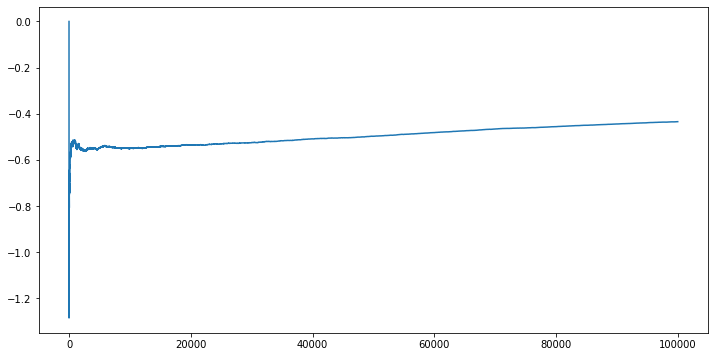

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_rewards_double_counting)

In [54]:
mean_rewards_double_counting[-1]

-0.43449

#### Основные выводы:
Дабл стратегия улучшает выигрыш по сравнению с базовой стратегией. А для обучения с подсчетом карт по всей видимоести не хватает количества экспериментов, поскольку количество состояний у нас резко увеличивается. Заметно, что стратегия с обучением карт еще не вышла к своей асимптоте.

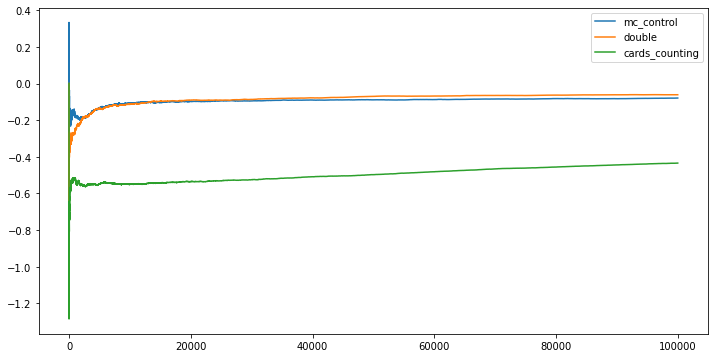

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_rewards_1, label="mc_control")
ax.plot(mean_rewards_double, label="double")
ax.plot(mean_rewards_double_counting, label="cards_counting")
plt.legend()